# Exercise 2 - Binary Classification and MLP

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# Repro helpers
def set_all_seeds(seed: int = 42):
    np.random.seed(seed)
    rng = np.random.default_rng(seed)
    return rng

def accuracy(y_true, y_pred) -> float:
    return float((y_true == y_pred).mean())

def train_test_split(X, y, test_size=0.2, seed=7):
    n = X.shape[0]
    idx = np.random.default_rng(seed).permutation(n)
    n_test = int(n * test_size)
    test_idx, train_idx = idx[:n_test], idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


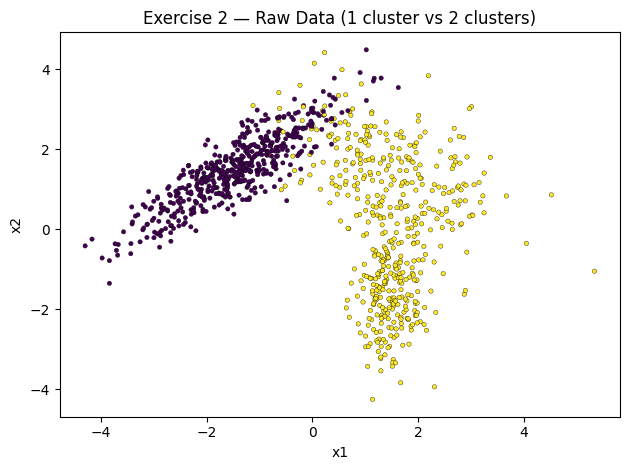

In [60]:
def _take_class(X, y, cls, n_needed):
    Xc = X[y == cls]
    if Xc.shape[0] < n_needed:
        raise ValueError("Increase n_samples in generator")
    return Xc[:n_needed]

def binary_1v2_clusters(n_total=1000, random_state=42, class_sep=1.5):
    n0 = n1 = n_total // 2

    Xa, ya = make_classification(
        n_samples=3*n0, n_features=2, n_informative=2, n_redundant=0,
        n_classes=2, n_clusters_per_class=1, class_sep=class_sep,
        flip_y=0.0, random_state=random_state
    )
    X0 = _take_class(Xa, ya, cls=0, n_needed=n0)

    Xb, yb = make_classification(
        n_samples=3*n1, n_features=2, n_informative=2, n_redundant=0,
        n_classes=2, n_clusters_per_class=2, class_sep=class_sep,
        flip_y=0.0, random_state=random_state + 1
    )
    X1 = _take_class(Xb, yb, cls=1, n_needed=n1)

    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])

    idx = np.random.default_rng(random_state + 2).permutation(n_total)
    return X[idx], y[idx]

rng = set_all_seeds(42)
X, y = binary_1v2_clusters(n_total=1000, random_state=42, class_sep=1.5)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=10, edgecolors="k", linewidths=0.25)
plt.title("Exercise 2 — Raw Data (1 cluster vs 2 clusters)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.savefig("images/ex2-raw.png")
plt.show()

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, seed=7)
ytr_b = ytr.reshape(-1, 1)


In [61]:
def tanh(z):      
    return np.tanh(z)
def dtanh(z):     
    a = np.tanh(z)
    return 1.0 - a*a
def sigmoid(z):   
    return 1.0 / (1.0 + np.exp(-z))
def softmax(z):
    zmax = z.max(axis=1, keepdims=True)
    e = np.exp(z - zmax)
    return e / e.sum(axis=1, keepdims=True)

class Dense:
    def __init__(self, in_dim, out_dim, activation=None, seed=None):
        self.in_dim, self.out_dim = in_dim, out_dim
        rng = np.random.default_rng(seed)
        std = np.sqrt(1.0 / in_dim)
        self.W = rng.normal(scale=std, size=(in_dim, out_dim))
        self.b = np.zeros(out_dim)
        self.activation = activation
        self._cache = {}

    def _act(self, z):
        if self.activation is None:         
            return z
        if self.activation == "tanh":       
            return tanh(z)
        if self.activation == "sigmoid":    
            return sigmoid(z)
        if self.activation == "softmax":
            return softmax(z)
        raise ValueError(f"unknown activation {self.activation}")

    def _dact(self, z):
        if self.activation is None:         
            return np.ones_like(z)
        if self.activation == "tanh":       
            return dtanh(z)
        if self.activation == "sigmoid":
            s = sigmoid(z)
            return s*(1.0 - s)
        if self.activation == "softmax":
            return None
        raise ValueError(f"unknown activation {self.activation}")

    def forward(self, X):
        Z = X @ self.W + self.b
        A = self._act(Z)
        self._cache["X"], self._cache["Z"], self._cache["A"] = X, Z, A
        return A

    def backward(self, dA, lr):
        X, Z, A = self._cache["X"], self._cache["Z"], self._cache["A"]
        if self.activation == "softmax":
            dZ = dA
        else:
            dZ = dA * self._dact(Z)
        dW = X.T @ dZ / X.shape[0]
        db = dZ.mean(axis=0)
        dX = dZ @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dX

In [62]:
class MLP:
    def __init__(self, layer_dims, hidden_activation="tanh", seed=None):
        self.layers = []
        rng = np.random.default_rng(seed)

        for i in range(len(layer_dims) - 1):
            act = hidden_activation if i < len(layer_dims) - 2 else "sigmoid"
            self.layers.append(
                Dense(layer_dims[i], layer_dims[i+1], activation=act,
                      seed=int(rng.integers(1 << 30)))
            )

    def forward(self, X):
        A = X
        for lyr in self.layers:
            A = lyr.forward(A)
        return A 

    def _bce_and_grad(self, A, y):
        eps = 1e-12
        A = np.clip(A, eps, 1.0 - eps)
        loss = -(y*np.log(A) + (1-y)*np.log(1-A)).mean()
        dZ = (A - y)
        return float(loss), dZ

    def fit(self, X, y, epochs=200, lr=1e-1, batch_size=64, seed=None, verbose=False):
        rng = np.random.default_rng(seed)
        n = X.shape[0]
        hist = {"loss": []}

        for ep in range(epochs):
            idx = rng.permutation(n)
            Xs, ys = X[idx], y[idx]
            ep_losses = []

            for i in range(0, n, batch_size):
                xb = Xs[i:i+batch_size]
                yb = ys[i:i+batch_size]
                A = self.forward(xb)
                loss, dZlast = self._bce_and_grad(A, yb)
                ep_losses.append(loss)

                dA = dZlast
                for lyr in reversed(self.layers):
                    dA = lyr.backward(dA, lr)

            hist["loss"].append(np.mean(ep_losses))
            if verbose and (ep+1) % 20 == 0:
                print(f"epoch {ep+1}: loss={hist['loss'][-1]:.4f}")
        return hist

    def predict(self, X):
        A = self.forward(X).ravel()
        return (A >= 0.5).astype(int)


epoch 20: loss=0.1630
epoch 40: loss=0.1385
epoch 60: loss=0.1313
epoch 80: loss=0.1210
epoch 100: loss=0.1173
epoch 120: loss=0.1164
epoch 140: loss=0.1141
epoch 160: loss=0.1131
epoch 180: loss=0.1119
epoch 200: loss=0.1102


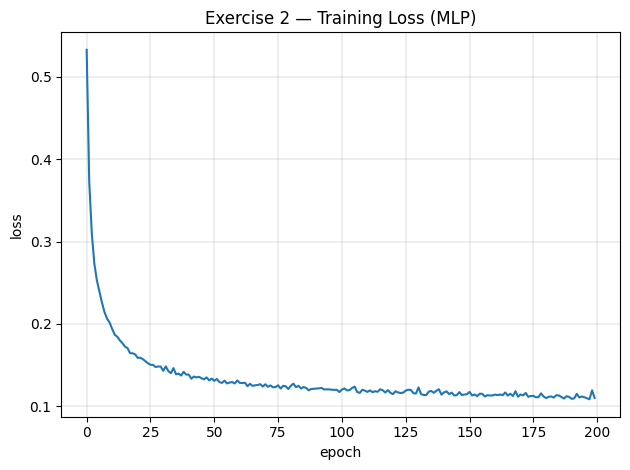

In [63]:
mlp = MLP(layer_dims=[2, 16, 1], hidden_activation="tanh", seed=7)
hist = mlp.fit(Xtr, ytr_b, epochs=200, lr=1e-1, batch_size=64, seed=0, verbose=True)

plt.figure()
plt.plot(hist["loss"])
plt.title("Exercise 2 — Training Loss (MLP)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.savefig("images/ex2-loss.png")
plt.show()

In [64]:
yp = mlp.predict(Xte)
acc = accuracy(yte, yp)
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.9400


In [65]:
conf_mat = confusion_matrix(yte, yp)
print(conf_mat)

[[107   4]
 [  8  81]]


# Exercise 3 — Multiclass with MLP

In [66]:
def one_hot(y: np.ndarray, num_classes: int) -> np.ndarray:
    oh = np.zeros((y.shape[0], num_classes), dtype=float)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

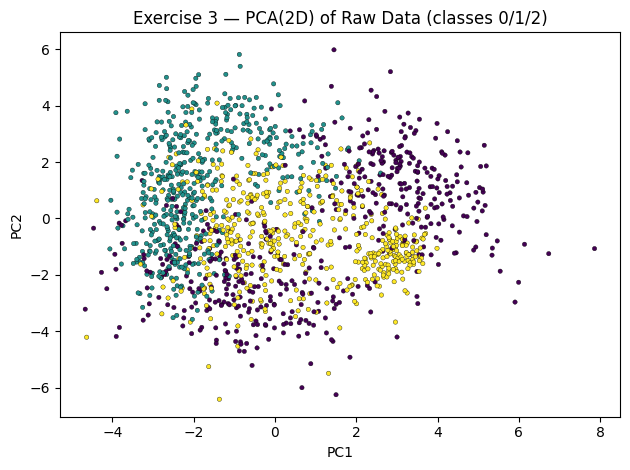

In [67]:
from sklearn.decomposition import PCA

def _take_class(X, y, cls, n_needed):
    Xc = X[y == cls]
    if Xc.shape[0] < n_needed:
        raise ValueError("Increase n_samples; not enough points for requested slice.")
    return Xc[:n_needed]

def multiclass_2_3_4_clusters(n_total=1500, random_state=42, class_sep=1.5):
    n_per = n_total // 3

    Xa, ya = make_classification(
        n_samples=3*n_per, n_features=4, n_informative=4, n_redundant=0,
        n_classes=3, n_clusters_per_class=2, class_sep=class_sep,
        flip_y=0.0, random_state=random_state
    )
    X0 = _take_class(Xa, ya, cls=0, n_needed=n_per)

    Xb, yb = make_classification(
        n_samples=3*n_per, n_features=4, n_informative=4, n_redundant=0,
        n_classes=3, n_clusters_per_class=3, class_sep=class_sep,
        flip_y=0.0, random_state=random_state+1
    )
    X1 = _take_class(Xb, yb, cls=1, n_needed=n_per)

    Xc, yc = make_classification(
        n_samples=3*n_per, n_features=4, n_informative=4, n_redundant=0,
        n_classes=3, n_clusters_per_class=4, class_sep=class_sep,
        flip_y=0.0, random_state=random_state+2
    )
    X2 = _take_class(Xc, yc, cls=2, n_needed=n_per)

    X = np.vstack([X0, X1, X2])
    y = np.hstack([
        np.zeros(n_per, dtype=int),
        np.ones(n_per, dtype=int),
        2*np.ones(n_per, dtype=int),
    ])

    idx = np.random.default_rng(random_state+3).permutation(n_total)
    return X[idx], y[idx]

X, y = multiclass_2_3_4_clusters(n_total=1500, random_state=42, class_sep=1.6)
pca = PCA(n_components=2, random_state=7).fit(X)
X2 = pca.transform(X)

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=y, s=10, edgecolors="k", linewidths=0.25)
plt.title("Exercise 3 — PCA(2D) of Raw Data (classes 0/1/2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("images/ex3-data-pca.png")
plt.show()

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, seed=7)
ytr_oh = one_hot(ytr, 3)

In [68]:
class MulticlassMLP:
    def __init__(self, layer_dims, hidden_activation="tanh", multiclass=True, seed=None):
        self.layers = []
        self.multiclass = multiclass
        rng = np.random.default_rng(seed)

        for i in range(len(layer_dims) - 1):
            act = hidden_activation if i < len(layer_dims) - 2 else ("softmax" if multiclass else None)
            self.layers.append(
                Dense(layer_dims[i], layer_dims[i+1], activation=act,
                      seed=int(rng.integers(1 << 30)))
            )

    def forward(self, X):
        A = X
        for lyr in self.layers:
            A = lyr.forward(A)
        return A

    def _softmax_ce_and_grad(self, P, Y_onehot):
        eps = 1e-12
        P = np.clip(P, eps, 1.0)
        loss = -(Y_onehot * np.log(P)).sum(axis=1).mean()
        dZ = (P - Y_onehot)
        return float(loss), dZ

    def fit(self, X, y_onehot, epochs=300, lr=1e-1, batch_size=64, seed=None, verbose=False):
        rng = np.random.default_rng(seed)
        n = X.shape[0]
        hist = {"loss": []}

        for ep in range(epochs):
            idx = rng.permutation(n)
            Xs, ys = X[idx], y_onehot[idx]
            ep_losses = []

            for i in range(0, n, batch_size):
                xb = Xs[i:i+batch_size]
                yb = ys[i:i+batch_size]

                P = self.forward(xb)        
                loss, dZlast = self._softmax_ce_and_grad(P, yb)
                ep_losses.append(loss)

                dA = dZlast
                for lyr in reversed(self.layers):
                    dA = lyr.backward(dA, lr)

            hist["loss"].append(np.mean(ep_losses))
            if verbose and (ep+1) % 25 == 0:
                print(f"epoch {ep+1:3d}: loss={hist['loss'][-1]:.4f}")
        return hist

    def predict(self, X):
        P = self.forward(X)
        return np.argmax(P, axis=1)

In [69]:
mlp3 = MulticlassMLP(layer_dims=[4, 32, 3], hidden_activation="tanh", multiclass=True, seed=7)
hist3 = mlp3.fit(Xtr, one_hot(ytr, 3), epochs=500, lr=1e-1, batch_size=64, seed=0, verbose=True)

epoch  25: loss=0.1952
epoch  50: loss=0.1543
epoch  75: loss=0.1276
epoch 100: loss=0.1094
epoch 125: loss=0.0964
epoch 150: loss=0.0864
epoch 175: loss=0.0818
epoch 200: loss=0.0748
epoch 225: loss=0.0713
epoch 250: loss=0.0670
epoch 275: loss=0.0634
epoch 300: loss=0.0594
epoch 325: loss=0.0567
epoch 350: loss=0.0546
epoch 375: loss=0.0508
epoch 400: loss=0.0498
epoch 425: loss=0.0478
epoch 450: loss=0.0454
epoch 475: loss=0.0435
epoch 500: loss=0.0423


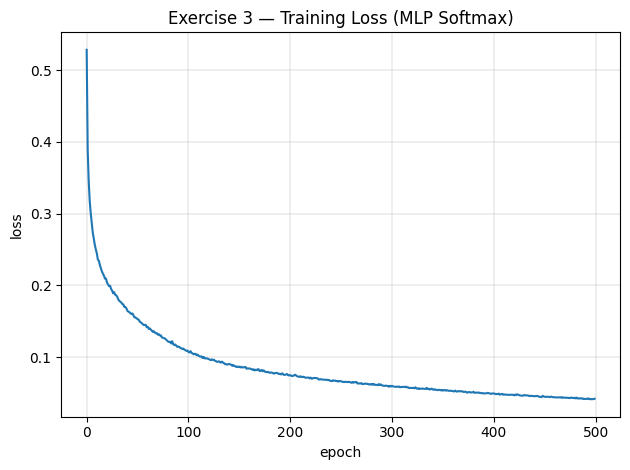

In [70]:
plt.figure()
plt.plot(hist3["loss"])
plt.title("Exercise 3 — Training Loss (MLP Softmax)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.savefig("images/ex3-loss.png")
plt.show()

In [71]:
yp3 = mlp3.predict(Xte)
acc3 = accuracy(yte, yp3)
print(f"Test accuracy: {acc3:.4f}")
conf_mat3 = confusion_matrix(yte, yp3)
print(conf_mat3)

Test accuracy: 0.9600
[[121   3   0]
 [  1  88   2]
 [  1   5  79]]


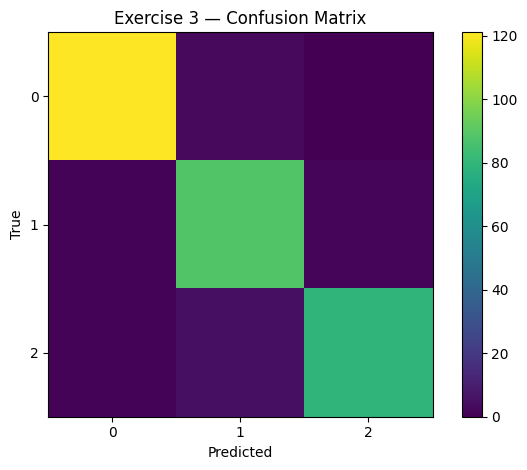

In [72]:
plt.figure()
plt.imshow(conf_mat3, interpolation="nearest")
plt.title("Exercise 3 — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0,1,2])
plt.yticks([0,1,2])
plt.tight_layout()
plt.savefig("images/ex3-confusion.png", dpi=160)
plt.show()

# Exercise 4 — Deeper MLP on multiclass dataset

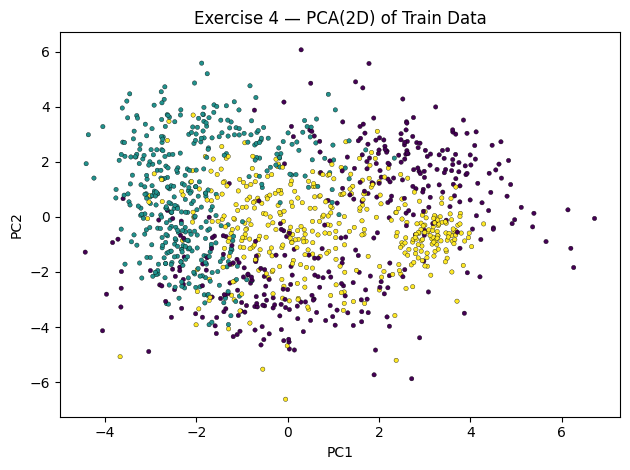

In [73]:
X, y = multiclass_2_3_4_clusters(n_total=1500, random_state=42, class_sep=1.6)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, seed=7)
ytr_oh = one_hot(ytr, 3)

pca_vis = PCA(n_components=2, random_state=9).fit(Xtr)
Xtr2 = pca_vis.transform(Xtr)

plt.figure()
plt.scatter(Xtr2[:,0], Xtr2[:,1], c=ytr, s=10, edgecolors="k", linewidths=0.25)
plt.title("Exercise 4 — PCA(2D) of Train Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("images/ex4-data-pca-train.png")
plt.show()

In [74]:
mlp4 = MulticlassMLP(layer_dims=[4, 64, 64, 32, 3], hidden_activation="tanh", multiclass=True, seed=11)
hist4 = mlp4.fit(Xtr, ytr_oh, epochs=500, lr=1e-1, batch_size=64, seed=0, verbose=True)

epoch  25: loss=0.1273
epoch  50: loss=0.0851
epoch  75: loss=0.0654
epoch 100: loss=0.0503
epoch 125: loss=0.0434
epoch 150: loss=0.0361
epoch 175: loss=0.0376
epoch 200: loss=0.0341
epoch 225: loss=0.0276
epoch 250: loss=0.0246
epoch 275: loss=0.0222
epoch 300: loss=0.0177
epoch 325: loss=0.0191
epoch 350: loss=0.0174
epoch 375: loss=0.0141
epoch 400: loss=0.0191
epoch 425: loss=0.0178
epoch 450: loss=0.0129
epoch 475: loss=0.0139
epoch 500: loss=0.0127


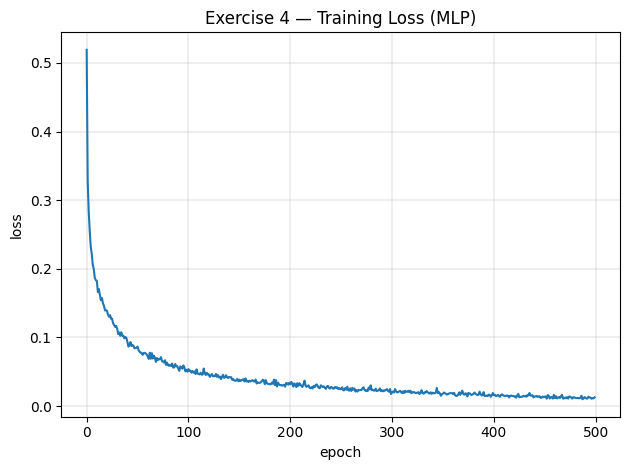

In [75]:
plt.figure()
plt.plot(hist4["loss"])
plt.title("Exercise 4 — Training Loss (MLP)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.savefig("images/ex4-loss.png")
plt.show()

In [76]:
yp4 = mlp4.predict(Xte)
acc4 = accuracy(yte, yp4)
print(f"Test accuracy: {acc4:.4f}")
conf_mat4 = confusion_matrix(yte, yp4)
print(conf_mat4)

Test accuracy: 0.9633
[[121   2   1]
 [  0  88   3]
 [  1   4  80]]


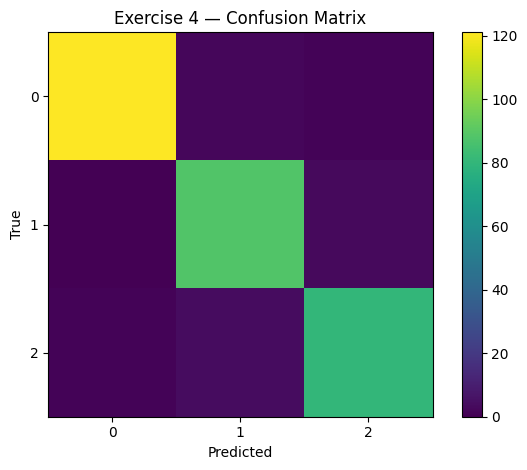

In [77]:
plt.figure()
plt.imshow(conf_mat4, interpolation="nearest")
plt.title("Exercise 4 — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks([0,1,2])
plt.yticks([0,1,2])
plt.tight_layout()
plt.savefig("images/ex4-confusion.png")
plt.show()